# 🦷 Teeth Classification Task

 * Objective: Automatically identify and categorize different types of teeth or dental conditions from images.
 * Purpose: Helps in diagnosis

* Challenge: Teeth may vary in shape, size, color, and alignment, making classification non-trivial.

* Dataset: Consists of labeled images divided into classes representing different tooth types or conditions.

## Import Required Libraries

In [2]:
## import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping ,ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [3]:
data_path = '/content/drive/MyDrive/Computer Vision Tasks - Cellula/week 1/Teeth_Dataset'
os.listdir(data_path)

['Testing', 'Training', 'Validation']

In [4]:
target_size = (224, 224)

In [5]:
for folder in os.listdir(data_path):
  print(f'{folder} contains {len(os.listdir(os.path.join(data_path, folder)))} images')

Testing contains 11 images
Training contains 7 images
Validation contains 7 images


## Build Image DataFrame

In [6]:
images_pathes= glob.glob(os.path.join(data_path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'ImageName': images_pathes})
df['Folder'] = df['ImageName'].apply(lambda x: x.split(os.sep)[-3])
df['Label'] = df['ImageName'].apply(lambda x: x.split(os.sep)[-2])

df = df.iloc[1:].reset_index(drop=True)


In [7]:
df

,ImageName,Folder,Label
0,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS
1,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS
2,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS
3,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS
4,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS
...,...,...,...
5636,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC
5637,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC
5638,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC
5639,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC


In [8]:
df['Folder'].value_counts()

,count
Folder,
Training,3094
Testing,1512
Validation,1035


In [9]:
df['Label'].value_counts()

,count
Label,
OLP,904
MC,903
CaS,802
CoS,749
OT,659
Gum,600
OC,543
outputs,161
out,160


In [10]:
labels_to_remove = ['outputs', 'out', 'output']
df = df[~df['Label'].isin(labels_to_remove)].reset_index(drop=True)

In [11]:
df['Label'].value_counts()

,count
Label,
OLP,904
MC,903
CaS,802
CoS,749
OT,659
Gum,600
OC,543


## Visualize Sample Images

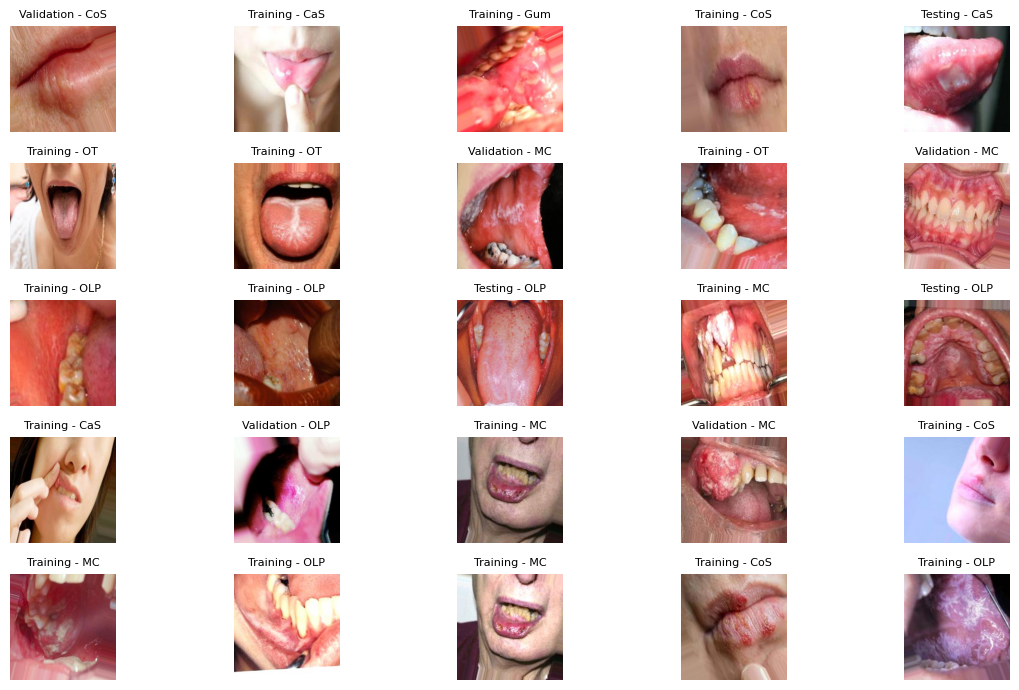

In [12]:
def show_sample(data=df, num_sample=25):
    plt.figure(figsize=(12, 7))

    sample_df = data.sample(num_sample).reset_index(drop=True)

    for i, image in sample_df.iterrows():
        img = cv2.imread(image['ImageName'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)

        # Title with folder + label
        plt.title(f"{image['Folder']} - {image['Label']}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_sample(df)

## Preprocess Images (Resize & Convert to RGB)

In [13]:
def preprocess_images(image, target_size=target_size):
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, target_size)
  return img

In [14]:
## Apply Preprocessing to Dataset
df['preprocessed_image'] = df['ImageName'].apply(preprocess_images)

In [15]:
df

,ImageName,Folder,Label,preprocessed_image
0,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS,"[[[244, 195, 163], [245, 196, 164], [248, 199,..."
1,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS,"[[[243, 187, 190], [242, 186, 189], [242, 186,..."
2,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS,"[[[232, 197, 169], [232, 197, 169], [232, 197,..."
3,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS,"[[[210, 172, 136], [204, 167, 131], [198, 162,..."
4,/content/drive/MyDrive/Computer Vision Tasks -...,Testing,CaS,"[[[205, 188, 180], [202, 185, 176], [201, 184,..."
...,...,...,...,...
5155,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC,"[[[214, 204, 202], [214, 204, 202], [214, 204,..."
5156,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC,"[[[189, 129, 101], [185, 125, 97], [179, 119, ..."
5157,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC,"[[[229, 219, 209], [229, 219, 209], [229, 219,..."
5158,/content/drive/MyDrive/Computer Vision Tasks -...,Validation,MC,"[[[255, 254, 255], [255, 253, 254], [255, 253,..."


## Display Preprocessed Image

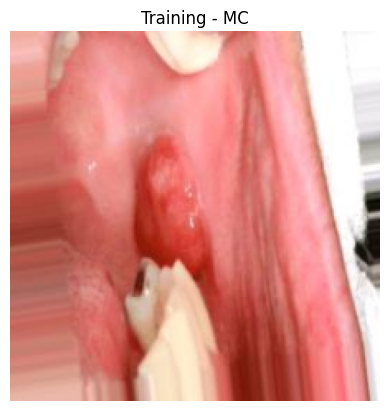

In [16]:
def show_preprocessed_images(data=df, sample_index=100):
  try :
    plt.title(f"{data['Folder'][sample_index]} - {data['Label'][sample_index]}")
    plt.imshow(data['preprocessed_image'][sample_index])
    plt.axis('off')
    plt.show()
  except:
    print('Image not found')

show_preprocessed_images(df, 2500)

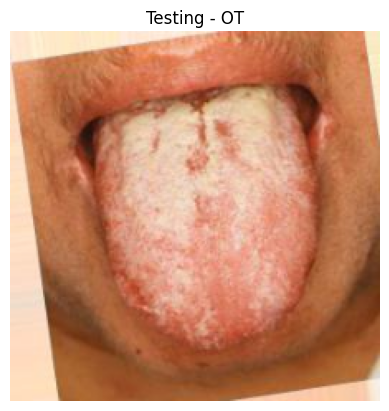

In [17]:
show_preprocessed_images(df, 1000)

## Encode Labels and Split Dataset (Train/Val/Test)

In [18]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [20]:
train_data = (df['Folder'] == 'Training')
val_data = (df['Folder'] == 'Validation')
test_data = (df['Folder'] == 'Testing')

print(f'Number of training samples: {train_data.sum()}')
print(f'Number of validation samples: {val_data.sum()}')
print(f'Number of testing samples: {test_data.sum()}')

Number of training samples: 3094
Number of validation samples: 1035
Number of testing samples: 1031


In [21]:
x = np.array(df['preprocessed_image'].tolist())
y = np.array(df['Label'])

## Encode Label

le = LabelEncoder()
y = le.fit_transform(y)
y_categorical = to_categorical(y, num_classes=len(le.classes_))

In [22]:
x_train, x_val, x_test = x[train_data], x[val_data], x[test_data]
y_train, y_val, y_test = y_categorical[train_data], y_categorical[val_data], y_categorical[test_data]

In [23]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')

print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')


x_train shape: (3094, 224, 224, 3)
y_train shape: (3094, 7)
x_val shape: (1035, 224, 224, 3)
y_val shape: (1035, 7)
x_test shape: (1031, 224, 224, 3)
y_test shape: (1031, 7)


In [24]:
y_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Create Data Generators (Augmentation & Rescaling)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    rescale=1./255
)

In [26]:
train_generator = train_gen.flow(
    x_train,
    y_train,
    batch_size=32
)

val_generator = val_gen.flow(
    x_val,
    y_val,
    batch_size=32
)

## Build CNN Model Architecture

In [45]:
# Define CNN model
model = Sequential([
    # Input layer
    Input(shape=(224, 224, 3)),


    # Convolution Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),

    # Convolution Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.1),

    # Convolution Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.1),

    # Convolution Layer 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

## Display Model Summary

In [46]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_14            │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_15            │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_16            │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_17            │ (None, 14, 14, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,082,631 (99.50 MB)

 Trainable params: 26,082,631 (99.50 MB)

 Non-trainable params: 0 (0.00 B)

### Compile CNN Model

In [47]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Define Training Callbacks (EarlyStopping, Checkpoint, LR Scheduler)

In [48]:
es = EarlyStopping(monitor='val_loss',
                   patience=3,
                   restore_best_weights=True)


model_checkpoint = ModelCheckpoint('best_model.keras',
                                   save_best_only=True)


lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7)

### Train CNN Model

In [49]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[es, model_checkpoint,lr])

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 507ms/step - accuracy: 0.1593 - loss: 1.9544 - val_accuracy: 0.2599 - val_loss: 1.9056 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - accuracy: 0.2139 - loss: 1.9097 - val_accuracy: 0.2705 - val_loss: 1.8030 - learning_rate: 1.0000e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 420ms/step - accuracy: 0.2419 - loss: 1.8637 - val_accuracy: 0.3005 - val_loss: 1.7438 - learning_rate: 1.0000e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 477ms/step - accuracy: 0.2374 - loss: 1.8489 - val_accuracy: 0.3623 - val_loss: 1.7058 - learning_rate: 1.0000e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 461ms/step - accuracy: 0.2773 - loss: 1.7700 - val_accuracy: 0.3643 - val_loss: 1.6444 - learning_rate: 1.0000e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.3180 - loss: 1.7453 - val_accuracy: 0.3894 - val_loss: 1.5987 - learning_rate: 1.0000e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - acc

### Plot Training & Validation Accuracy/Loss

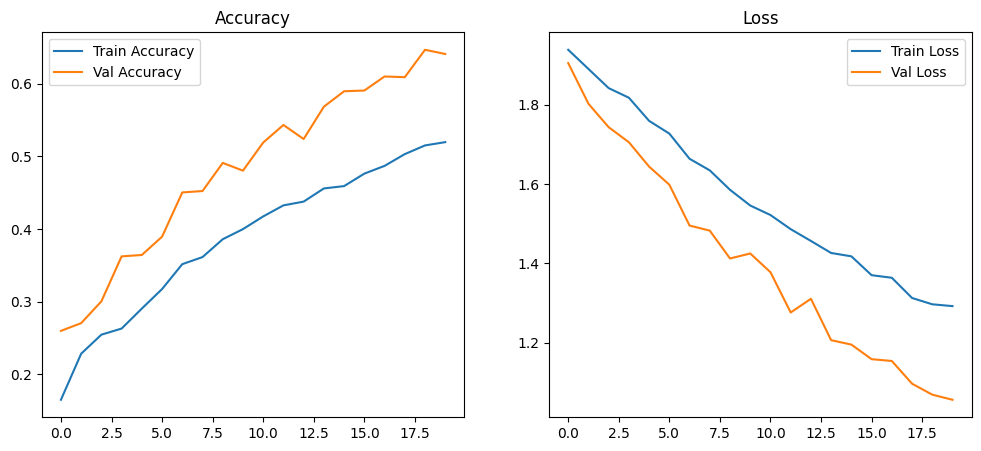

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Evaluate Model on Test Data (Accuracy, Report & Confusion Matrix)

In [84]:
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5726 - loss: 78.1873
Test Accuracy: 0.5577


In [86]:
x_test_norm = x_test / 255.0

# Predict probabilities for all test images
y_pred_probs = model.predict(x_test_norm, verbose=1)

# Convert to predicted & True class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [88]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 64.79%


              precision    recall  f1-score   support

         CaS       0.53      0.72      0.61       160
         CoS       0.71      0.83      0.76       149
         Gum       0.72      0.64      0.68       120
          MC       0.63      0.66      0.65       181
          OC       0.72      0.49      0.58       108
         OLP       0.66      0.60      0.63       180
          OT       0.70      0.54      0.61       133

    accuracy                           0.65      1031
   macro avg       0.67      0.64      0.64      1031
weighted avg       0.66      0.65      0.65      1031



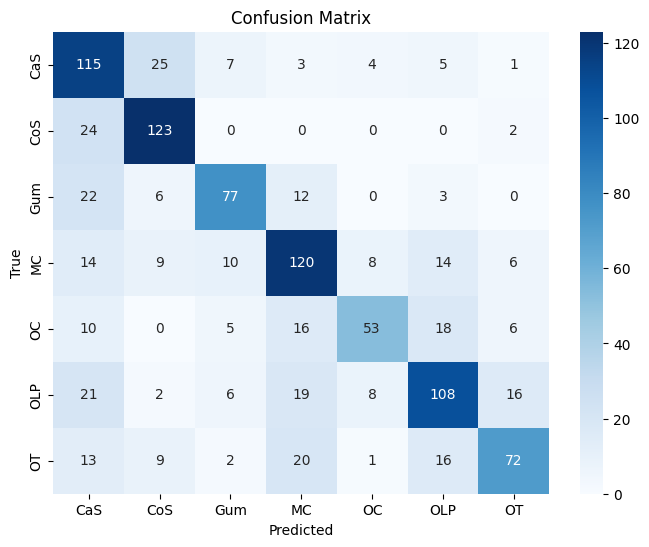

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = le.classes_

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Visualize Sample Predictions (True vs Predicted Labels)

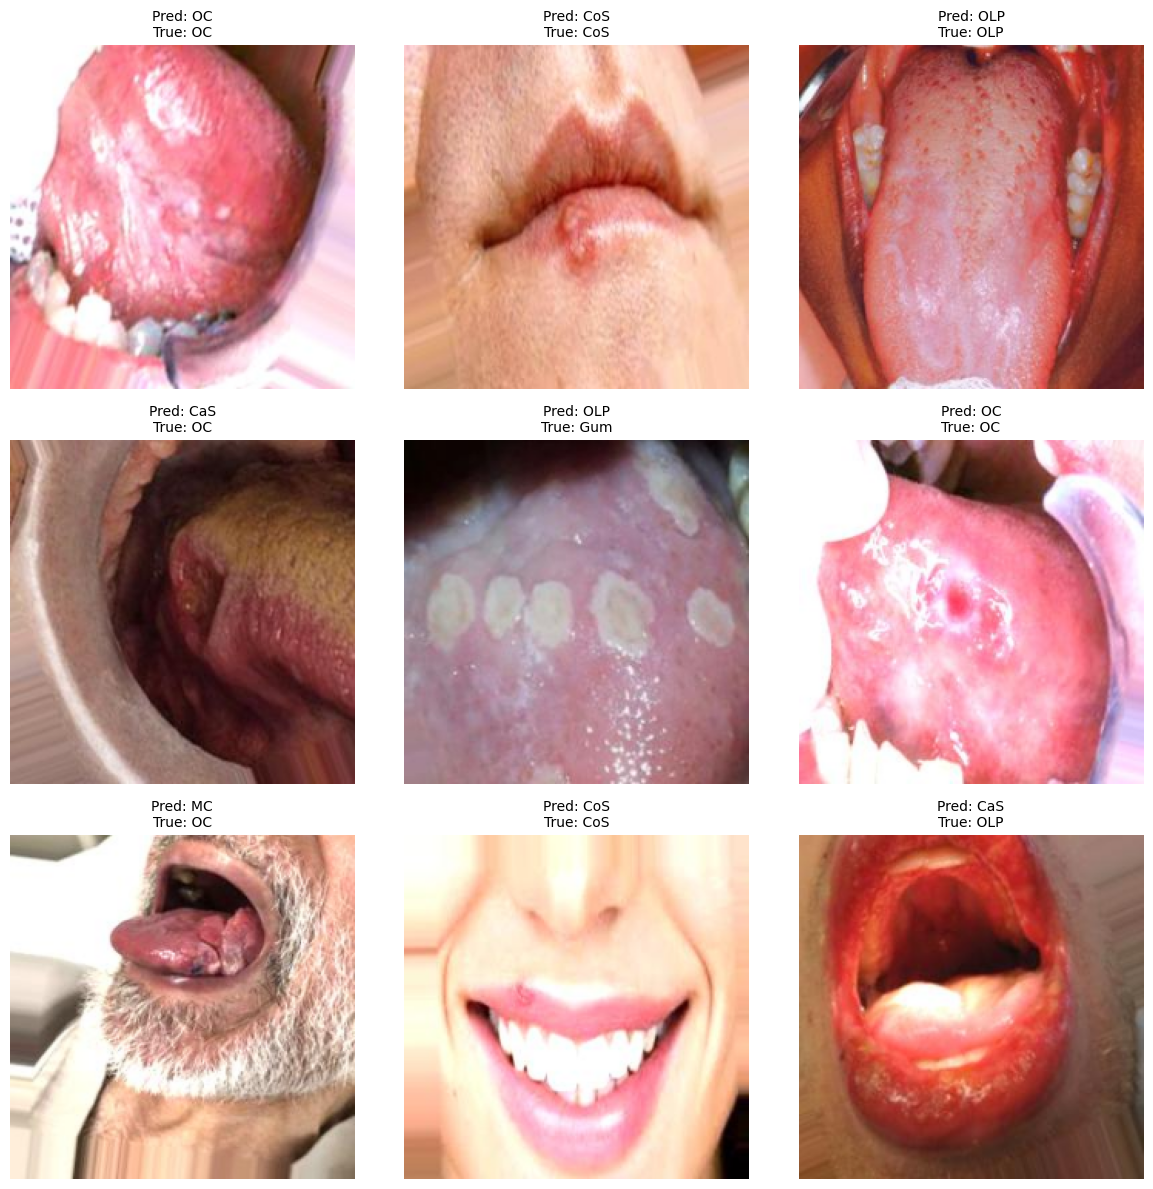

In [93]:
import random

# Pick random 9 images from test set
indices = random.sample(range(len(x_test)), 9)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img = x_test[idx]
    pred_class = y_pred_classes[idx]
    true_class = y_true[idx]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_labels[pred_class]}\nTrue: {class_labels[true_class]}", fontsize=10)

plt.tight_layout()
plt.show()